<a href="https://colab.research.google.com/github/DarkDevil1306/DCU-Net/blob/main/Final_CASIA_DCUNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**DCU-Net: a dual-channel U-shaped network for image splicing forgery detection**

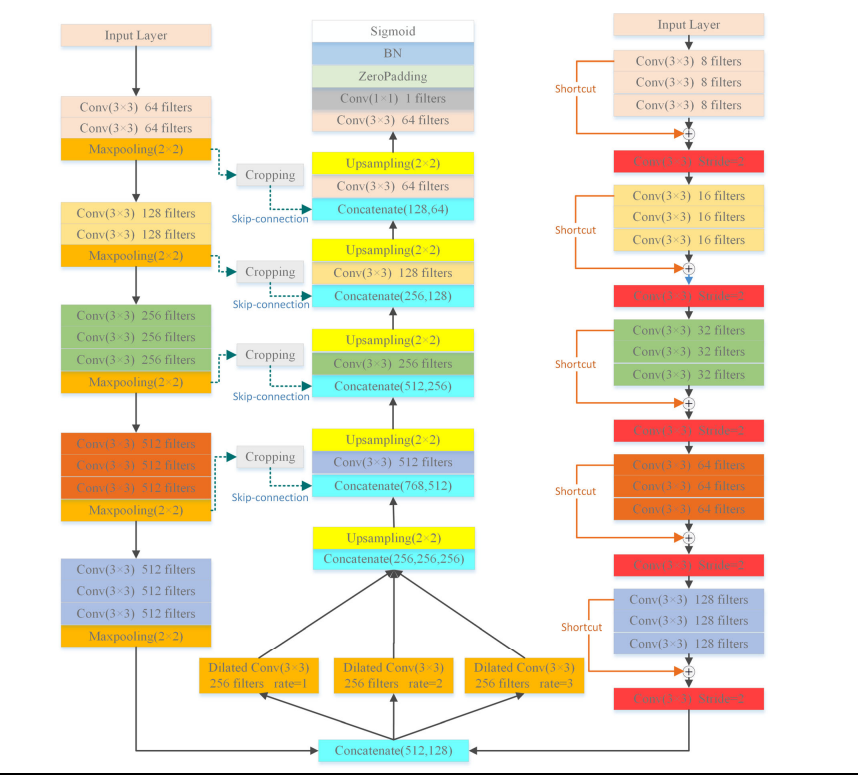

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE = [256,256]

tampered_path = '/content/drive/MyDrive/CASIA/CASIA2.0_revised/Tp'

In [ ]:
train_path = '/content/drive/MyDrive/CASIA/CASIA2.0_revised/train'
test_path = '/content/drive/MyDrive/CASIA/CASIA2.0_revised/test'

In [ ]:
!mkdir -p $train_path
!mkdir -p $test_path

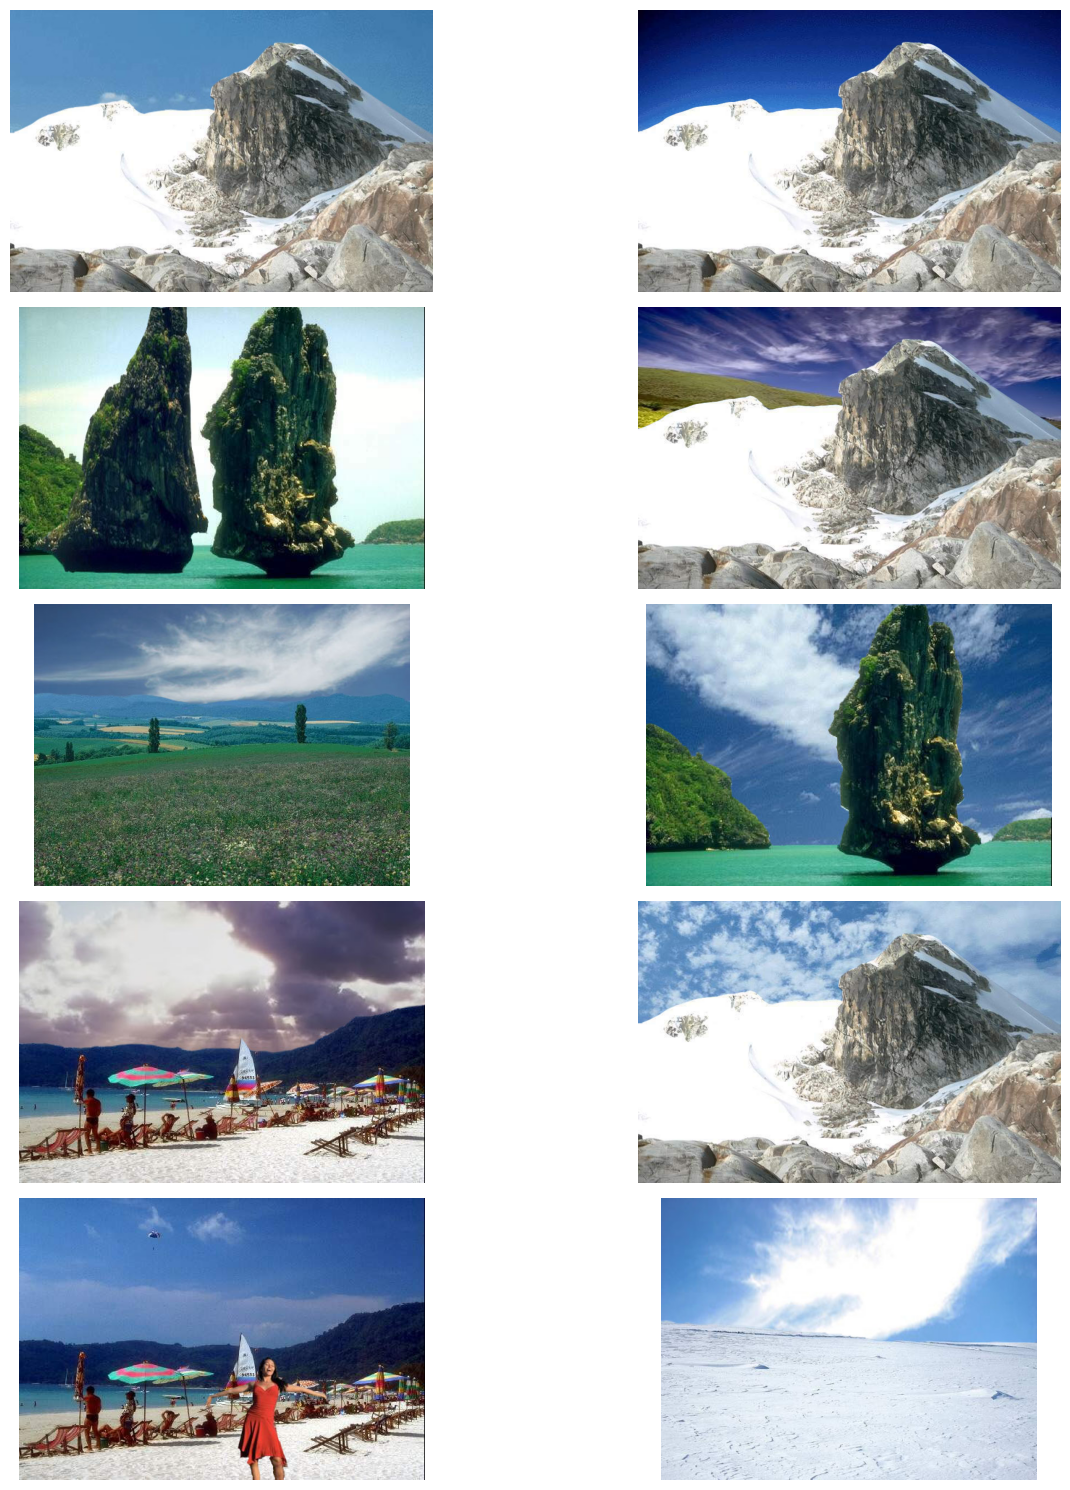

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

# Define the path to the directory containing the .tif images
extracted_images_path = tampered_path

# Get a list of all .tif files in the directory
all_images = [file for file in os.listdir(extracted_images_path) if file.startswith('Tp_D')]

# Select only the first 100 .tif image files
selected_images = all_images[:10]  # Adjust to select a different number of images

# Set up the plot to display the images in a montage
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

# Display the selected .tif images in a 10x10 grid
for i, ax in enumerate(axes.flat):
    image_path = os.path.join(extracted_images_path, selected_images[i])
    image = Image.open(image_path)
    ax.imshow(np.array(image))
    ax.axis('off')

plt.tight_layout()
plt.show()


#####**TRAINING OF THE DATASETS**

In [ ]:
import shutil
import random
train_ratio = 0.8  # Modify as needed
image_count = 100
for filename in os.listdir(tampered_path):
  if not image_count:
    break
  if filename.startswith("Tp_D_"):
    image_count -= 1
    if random.random() < train_ratio:
      shutil.copy(os.path.join(tampered_path, filename), os.path.join(train_path, filename))
    else:
      shutil.copy(os.path.join(tampered_path, filename), os.path.join(test_path, filename))

<ipython-input-7-55e717f830bd>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((224, 224), Image.ANTIALIAS)


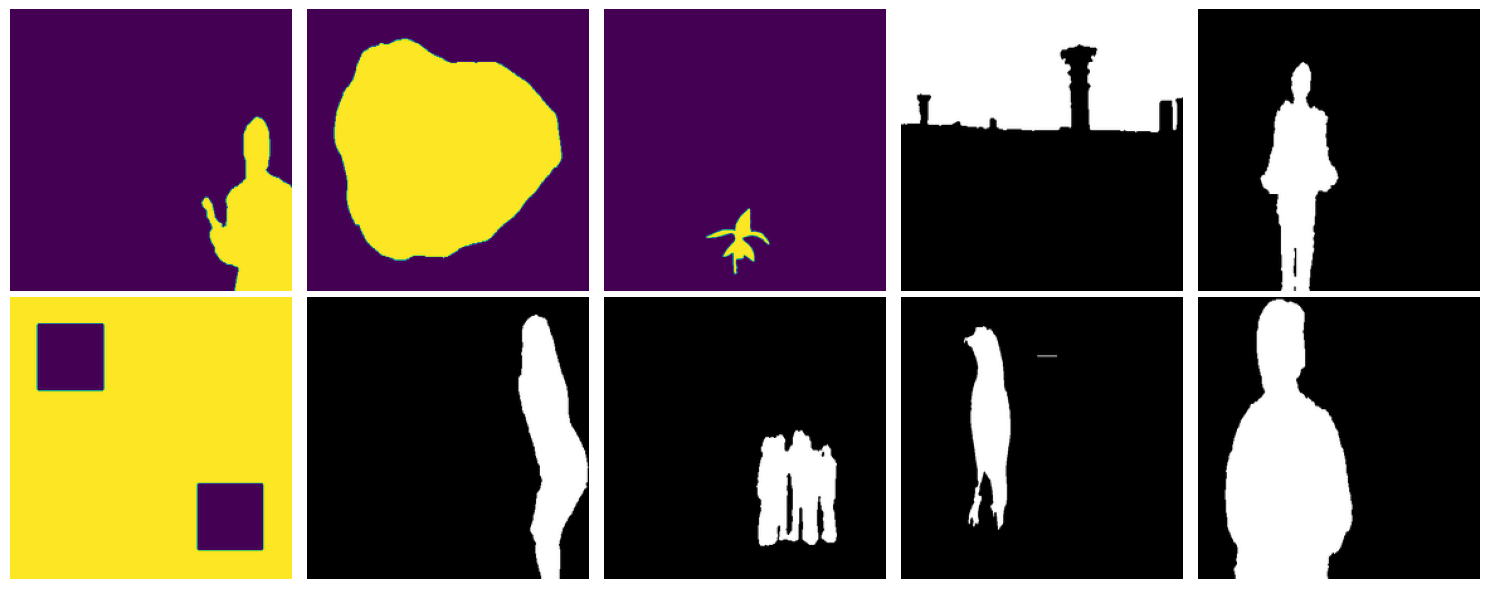

In [ ]:
import os
import zipfile
from PIL import Image

# Define paths
# groundtruth_zip_path = '/content/drive/MyDrive/CASIA2.0_Groundtruth.zip'
groundtruth_extract_path = '/content/drive/MyDrive/CASIA/CASIA2.0_Groundtruth'

# Create the extraction directory if it doesn't exist
if not os.path.exists(groundtruth_extract_path):
    os.makedirs(groundtruth_extract_path)

# Function to extract images from a zip file
# def extract_images_from_zip(zip_path, extract_path):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_path)

# Extract ground truth images
# extract_images_from_zip(groundtruth_zip_path, groundtruth_extract_path)

# Display or process the extracted images (similar to your existing code)
groundtruth_images = [file for file in os.listdir(groundtruth_extract_path) if file.startswith('Tp_D')]

# Example: Display the first 10 ground truth images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    image_path = os.path.join(groundtruth_extract_path, groundtruth_images[i])
    image = Image.open(image_path)
    image = image.resize((224, 224), Image.ANTIALIAS)
    ax.imshow(np.array(image))
    ax.axis('off')

plt.tight_layout()
plt.show()

### Residual Image Creation

In [ ]:
import cv2
import os

# Define the directory containing your dataset
dataset_dir = '/content/drive/MyDrive/CASIA/CASIA2.0_revised/train'
output_dir = '/content/drive/MyDrive/CASIA/CASIA2.0_revised/residual_images'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to apply Gaussian blur
def apply_gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Function to create a residual image
def create_residual_image(original_image, smoothed_image):
    return cv2.subtract(original_image, smoothed_image)

# Iterate over the images in the dataset directory
for filename in os.listdir(dataset_dir):
    if filename:
        image_path = os.path.join(dataset_dir, filename)
        original_image = cv2.imread(image_path)
        smoothed_image = apply_gaussian_blur(original_image)
        residual_image = create_residual_image(original_image, smoothed_image)

        # Save the residual image in the output directory
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, residual_image)


### VGG16 Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Activation

def conv_block(input_tensor, filters, kernel_size=(3, 3), activation='relu', padding='same', block_name='block'):
    x = Conv2D(filters, kernel_size, padding=padding, name=f'conv_{block_name}')(input_tensor)
    x = BatchNormalization(name=f'bn_{block_name}')(x)
    x = Activation(activation, name=f'act_{block_name}')(x)
    return x

def maxpool_block(input_tensor, pool_size=(2, 2), strides=(2, 2), block_name='block'):
    return MaxPool2D(pool_size=pool_size, strides=strides, name=f'maxpool_{block_name}')(input_tensor)

skip_tensor = []

def vgg16_model(inputs, classes=100):

    # Block 1
    x = conv_block(inputs, 64, block_name='1_1')
    x = conv_block(x, 64, block_name='1_2')
    x = maxpool_block(x, block_name='1')
    skip_tensor.append(x)

    # Block 2
    x = conv_block(x, 128, block_name='2_1')
    x = conv_block(x, 128, block_name='2_2')
    x = maxpool_block(x, block_name='2')
    skip_tensor.append(x)

    # Block 3
    x = conv_block(x, 256, block_name='3_1')
    x = conv_block(x, 256, block_name='3_2')
    x = conv_block(x, 256, block_name='3_3')
    x = maxpool_block(x, block_name='3')
    skip_tensor.append(x)

    # Block 4
    x = conv_block(x, 512, block_name='4_1')
    x = conv_block(x, 512, block_name='4_2')
    x = conv_block(x, 512, block_name='4_3')
    x = maxpool_block(x, block_name='4')
    skip_tensor.append(x)

    # Block 5
    x = conv_block(x, 512, block_name='5_1')
    x = conv_block(x, 512, block_name='5_2')
    x = conv_block(x, 512, block_name='5_3')
    x = maxpool_block(x, block_name='5')

    # # Fully connected layers
    # x = Flatten(name='flatten')(x)
    # x = Dense(4096, activation='relu', name='fc1')(x)
    # x = Dense(4096, activation='relu', name='fc2')(x)
    # x = Dense(classes, activation='softmax', name='predictions')(x)
    print("vgg16: ",x.shape)

    return x;

### ResNet50 Model

In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add
from keras.models import Model

def residual_block(x, filters, stride=1):
    # Shortcut
    shortcut = x

    # First layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second layer
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Adding the shortcut after the second layer
    if stride != 1:
        # If stride is not 1, adjust the dimension of the shortcut before adding
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding='same')(shortcut)
    x = Add()([x, shortcut])

    # Final ReLU
    x = ReLU()(x)
    return x

def create_resnet(inputs, num_blocks_list=[2, 2, 2, 2, 2]):
    # Initial conv layer
    x = Conv2D(8, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Creating the subsequent residual blocks
    num_filters = 8
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            stride = 2 if j == 0 and i != 0 else 1  # Apply stride only for the first block in each group except the very first one
            x = residual_block(x, num_filters, stride)
        num_filters *= 2  # Double the number of filters at each new group of blocks

    # Create model
    print("resnet: ",x.shape)
    return x;

# Example: Create a ResNet-like model with 3 groups of residual blocks
# resnet_model = create_resnet(input_shape=(256, 256, 3), num_blocks_list=[2, 2, 2, 2, 2])


### Feature Fusion

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Activation
from keras.layers import Concatenate, Input, UpSampling2D, AveragePooling2D

def dilated_conv_block(input_tensor, num_filters, dilation_rate, kernel_size=3, activation='relu', padding='same'):
    """Dilated convolutional block with activation."""
    x = Conv2D(num_filters, kernel_size, padding=padding, dilation_rate=dilation_rate)(input_tensor)
    x = Activation(activation)(x)
    return x

# vgg_output = vgg_model.output
# resnet_output = resnet_model.output
# resnet50_pooled = AveragePooling2D(pool_size=(2, 2))(resnet_output)

def feature_fusion(vgg_output, resnet50_pooled):
    # First fusion of the deep features from the two channels
    fused = Concatenate()([vgg_output, resnet50_pooled])

    # Multi-scale dilated convolution fusion
    dilated_1 = dilated_conv_block(fused, 256, dilation_rate=1)
    dilated_2 = dilated_conv_block(fused, 256, dilation_rate=2)
    dilated_3 = dilated_conv_block(fused, 256, dilation_rate=3)

    # Second fusion after multi-scale dilated convolution
    fused_dilated = Concatenate()([dilated_1, dilated_2, dilated_3])
    fused_dilated = UpSampling2D(size=(2, 2))(fused_dilated)
    print("feature fusion: ",fused_dilated.shape)

    return fused_dilated;

# Build the model using the outputs of the VGG16 and ResNet models
# fusion_model_output = feature_fusion(vgg_output, resnet_output)


### Feature Decoder

In [ ]:
from keras.layers import Conv2D, UpSampling2D, Concatenate
from keras.layers import Input, Conv2D, BatchNormalization, Activation, ZeroPadding2D
from keras.models import Model

def upsample_concat_block(input_tensor, skip_tensor, filters, block_name='block'):
    concat = Concatenate(name=f'concat_{block_name}')([input_tensor, skip_tensor])
    conv = conv_block(concat, filters, block_name=f'{block_name}_1')
    up = UpSampling2D(size=(2, 2), name=f'upsample_{block_name}')(conv)
    return up

# decoder_input = fusion_model_output

def feature_decoder(decoder_input):
  x = upsample_concat_block(decoder_input, skip_tensor[-1], 512, block_name='6')
  x = upsample_concat_block(x, skip_tensor[-2], 256, block_name='7')
  x = upsample_concat_block(x, skip_tensor[-3], 128, block_name='8')
  x = upsample_concat_block(x, skip_tensor[-4], 64, block_name='9')
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = Conv2D(1, (1, 1))(x)
  print("feature decoder before zeropadding: ",x.shape)
  # x = ZeroPadding2D(padding=(1, 1))(x)
  x = BatchNormalization()(x)
  x = Activation('sigmoid')(x)
  return x;

# final_output=feature_decoder(decoder_input)

In [ ]:
import tensorflow as tf

def apply_gaussian_blur_tf(inputs, kernel_size=(5, 5), sigma=0):
    # Convert the input tensor to float32
    inputs = tf.cast(inputs, tf.float32)

    # Create a Gaussian blur filter
    filter_weights = tf.constant([[1, 4, 6, 4, 1],
                                  [4, 16, 24, 16, 4],
                                  [6, 24, 36, 24, 6],
                                  [4, 16, 24, 16, 4],
                                  [1, 4, 6, 4, 1]], dtype=tf.float32) / 256.0
    filter_weights = tf.reshape(filter_weights, (*kernel_size, 1, 1))
    filter_weights = tf.tile(filter_weights, [1, 1, tf.shape(inputs)[-1], 1])

    # Apply depthwise convolution
    blurred = tf.nn.depthwise_conv2d(inputs, filter_weights, strides=[1, 1, 1, 1], padding='SAME')

    # Subtract the blurred image from the original to get the residual
    residual = tf.subtract(inputs, blurred)

    return residual


In [ ]:
def dcunet(input_shape):
  inputs=Input(input_shape)
  normal_image=inputs
  residual_image=apply_gaussian_blur_tf(inputs)
  vgg_output=vgg16_model(normal_image)
  resnet_output=create_resnet(residual_image)
  resnet50_pooled = AveragePooling2D(pool_size=(2, 2))(resnet_output)
  fusion_model_output = feature_fusion(vgg_output, resnet50_pooled)
  output=feature_decoder(fusion_model_output)
  print("final output :",output.shape)
  return Model(inputs,output)

In [ ]:
dcunet(input_shape=(256,256,3))

vgg16:  (None, 8, 8, 512)
resnet:  (None, 16, 16, 128)
feature fusion:  (None, 16, 16, 768)
feature decoder before zeropadding:  (None, 256, 256, 1)
final output : (None, 256, 256, 1)


In [ ]:
import os
from sklearn.model_selection import train_test_split

# Define the ratio for splitting (e.g., 967 for training, 95 for testing)
train_size = 967
test_size = 95

# Step 1: Split all_images into training and test sets
all_images_train, all_images_test = train_test_split(all_images, train_size=train_size, test_size=test_size, random_state=42)

# Step 2: Process training data
groundtruth_train = []
filtered_all_images_train = []

for filename in all_images_train:
    base_filename = os.path.splitext(os.path.basename(filename))[0]
    matching_groundtruth = next((gt for gt in groundtruth_images if os.path.splitext(os.path.basename(gt))[0].replace('_gt', '') == base_filename), None)

    if matching_groundtruth:
        groundtruth_train.append(matching_groundtruth)
        filtered_all_images_train.append(filename)

# Update all_images_train with filtered list
all_images_train = filtered_all_images_train

# Step 3: Process test data
groundtruth_test = []
filtered_all_images_test = []

for filename in all_images_test:
    base_filename = os.path.splitext(os.path.basename(filename))[0]
    matching_groundtruth = next((gt for gt in groundtruth_images if os.path.splitext(os.path.basename(gt))[0].replace('_gt', '') == base_filename), None)

    if matching_groundtruth:
        groundtruth_test.append(matching_groundtruth)
        filtered_all_images_test.append(filename)

# Update all_images_test with filtered list
all_images_test = filtered_all_images_test

# Now you have separate lists for training and test data along with their respective filenames
print("Training Data:")
print("Number of All Images (Training):", len(all_images_train))
print("Number of Groundtruth Images (Training):", len(groundtruth_train))
print("All Images:", all_images_train)
print("Groundtruth Images:", groundtruth_train)

print("\nTest Data:")
print("Number of All Images (Test):", len(all_images_test))
print("Number of Groundtruth Images (Test):", len(groundtruth_test))
print("All Images:", all_images_test)
print("Groundtruth Images:", groundtruth_test)


Training Data:
Number of All Images (Training): 967
Number of Groundtruth Images (Training): 967
All Images: ['Tp_D_NRN_M_N_cha10168_nat10123_12303.jpg', 'Tp_D_NRD_M_N_arc00010_nat00062_11177.jpg', 'Tp_D_NNN_S_B_cha00029_pla00030_20105.tif', 'Tp_D_NRN_S_N_pla00091_ani00031_00935.tif', 'Tp_D_NRN_M_N_sec10115_cha00062_11533.jpg', 'Tp_D_NRN_M_N_cha10170_nat10123_12291.jpg', 'Tp_D_NRN_S_B_ani00036_ani00037_00156.tif', 'Tp_D_NNN_M_B_sec00015_sec00082_00036.tif', 'Tp_D_NRD_S_N_cha10002_cha10001_20094.jpg', 'Tp_D_NRN_M_N_cha00085_ani10104_10029.tif', 'Tp_D_NRN_S_N_nat10131_ani00005_11903.jpg', 'Tp_D_NRN_S_N_ani10119_ani10118_11612.jpg', 'Tp_D_NRN_S_B_ind00094_cha00026_00488.tif', 'Tp_D_NRN_S_N_art00046_sec00099_00520.tif', 'Tp_D_NNN_S_N_nat00003_cha00096_00623.tif', 'Tp_D_NRN_M_N_art00052_art00065_10020.tif', 'Tp_D_NRD_S_N_cha10146_cha10144_12232.jpg', 'Tp_D_NNN_M_N_sec00030_nat00097_00051.tif', 'Tp_D_CNN_S_N_txt00052_txt00051_10377.tif', 'Tp_D_NRN_S_N_art10106_cha00067_11593.jpg', 'Tp_D_NRN_

In [ ]:
import os
import numpy as np
from PIL import Image

def load_images(image_paths, root_path, target_size=(128, 128), is_ground_truth=False):
    images = []
    for image_name in image_paths:
        image_path = os.path.join(root_path, image_name)
        image = Image.open(image_path)
        image = image.resize(target_size, Image.LANCZOS)

        # Convert to grayscale (single channel) only for ground truth
        if is_ground_truth:
            image = image.convert('L')
            # Threshold the pixel values to 0 or 1
            image = np.array(image) / 255.0  # Normalize pixel values to the range [0, 1]
            image_array = np.where(image > 0.5, 1.0, 0.0)  # Thresholding
        else:
            image_array = np.array(image) / 255.0  # Normalize pixel values to the range [0, 1]


        # Exclude alpha channel adjustment for non-ground truth images
        if not is_ground_truth and image_array.shape[2] == 4:
            # Discard the alpha channel
            image_array = image_array[:, :, :3]

        if is_ground_truth:
            image_array = np.expand_dims(image_array, axis=-1)  # Expand dimensions for single-channel images

        images.append(image_array)

    return np.array(images)



# Load training images and groundtruth images
x_train = load_images(all_images_train, extracted_images_path)
y_train = load_images(groundtruth_train, groundtruth_extract_path, is_ground_truth=True)

# Load test images and groundtruth images without conversion
x_test = load_images(all_images_test, extracted_images_path)
y_test = load_images(groundtruth_test, groundtruth_extract_path, is_ground_truth=True)


print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(967, 128, 128, 3) (967, 128, 128, 1)
(95, 128, 128, 3) (95, 128, 128, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

# Custom Weighted Binary Cross-Entropy Loss Function
def weighted_binary_cross_entropy(y_true, y_pred):
    pos_weight=2.0
    # Calculate the weighted binary cross entropy loss
    loss = -tf.reduce_mean(pos_weight * y_true * tf.math.log(y_pred + 1e-7) +
                           (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))

    return loss

# Define the model based on the DCU-Net architecture
model = dcunet(input_shape=(128,128,3))

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001,weight_decay=0.01)
model.compile(optimizer=optimizer, loss=weighted_binary_cross_entropy, metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Define training parameters
epochs_stage1 = 100
epochs_stage2 = 200
batch_size = 16

vgg16:  (None, 4, 4, 512)
resnet:  (None, 8, 8, 128)
feature fusion:  (None, 8, 8, 768)
feature decoder before zeropadding:  (None, 128, 128, 1)
final output : (None, 128, 128, 1)


In [ ]:
history_stage1 = model.fit(x_train, y_train, epochs=epochs_stage1, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/100
49/49 [==============================] - 63s 448ms/step - loss: 0.7429 - precision: 0.2467 - recall: 0.6564 - accuracy: 0.6898 - val_loss: 0.8166 - val_precision: 0.1426 - val_recall: 0.9232 - val_accuracy: 0.2629
Epoch 2/100
49/49 [==============================] - 10s 196ms/step - loss: 0.7005 - precision: 0.2992 - recall: 0.7021 - accuracy: 0.7434 - val_loss: 0.7922 - val_precision: 0.1302 - val_recall: 0.5431 - val_accuracy: 0.4648
Epoch 3/100
49/49 [==============================] - 10s 198ms/step - loss: 0.6832 - precision: 0.3215 - recall: 0.7201 - accuracy: 0.7623 - val_loss: 0.8381 - val_precision: 0.1629 - val_recall: 0.6818 - val_accuracy: 0.4995
Epoch 4/100
49/49 [==============================] - 10s 214ms/step - loss: 0.6547 - precision: 0.3481 - recall: 0.7327 - accuracy: 0.7835 - val_loss: 1.0497 - val_precision: 0.1358 - val_recall: 0.9586 - val_accuracy: 0.1958
Epoch 5/100
49/49 [==============================] - 11s 215ms/step - loss: 0.6296 - precision: 

In [ ]:
model.optimizer.lr.assign(0.00001)  # Set learning rate for the second stage
history_stage2 = model.fit(x_train, y_train, epochs=epochs_stage2, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/200
49/49 [==============================] - 11s 216ms/step - loss: 0.2937 - precision: 0.9334 - recall: 0.9953 - accuracy: 0.9900 - val_loss: 0.4942 - val_precision: 0.6411 - val_recall: 0.5607 - val_accuracy: 0.9013
Epoch 2/200
49/49 [==============================] - 10s 200ms/step - loss: 0.2940 - precision: 0.9448 - recall: 0.9962 - accuracy: 0.9918 - val_loss: 0.4894 - val_precision: 0.6739 - val_recall: 0.5548 - val_accuracy: 0.9065
Epoch 3/200
49/49 [==============================] - 10s 211ms/step - loss: 0.2929 - precision: 0.9407 - recall: 0.9968 - accuracy: 0.9913 - val_loss: 0.4865 - val_precision: 0.6793 - val_recall: 0.5602 - val_accuracy: 0.9078
Epoch 4/200
49/49 [==============================] - 10s 213ms/step - loss: 0.2928 - precision: 0.9460 - recall: 0.9966 - accuracy: 0.9920 - val_loss: 0.4869 - val_precision: 0.6909 - val_recall: 0.5498 - val_accuracy: 0.9088
Epoch 5/200
49/49 [==============================] - 10s 201ms/step - loss: 0.2913 - precision: 

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Convert pixel values to binary labels based on a threshold
threshold = 0.5
binary_y_test = (y_test > threshold).astype(int)
binary_predictions = (model.predict(x_test) > threshold).astype(int)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(binary_y_test.flatten(), binary_predictions.flatten(), average='binary')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

3/3 [==============================] - 13s 3s/step
Precision: 0.7297542103566329
Recall: 0.5282318557124918
F1 Score: 0.6128516541605424


In [ ]:
from sklearn.metrics import accuracy_score

y_pred=model.predict(x_test)

threshold = 0.5  # Adjust the threshold based on your problem

# Convert probabilities to binary predictions based on the threshold
y_pred_threshold =  (y_pred > threshold).astype('uint8')

# Flatten the arrays for accuracy calculation
y_test_flat = y_test.flatten().astype('uint8')
y_pred_flat = y_pred_threshold.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)

print(f'Accuracy: {accuracy}')


3/3 [==============================] - 0s 91ms/step
Accuracy: 0.9228310032894737


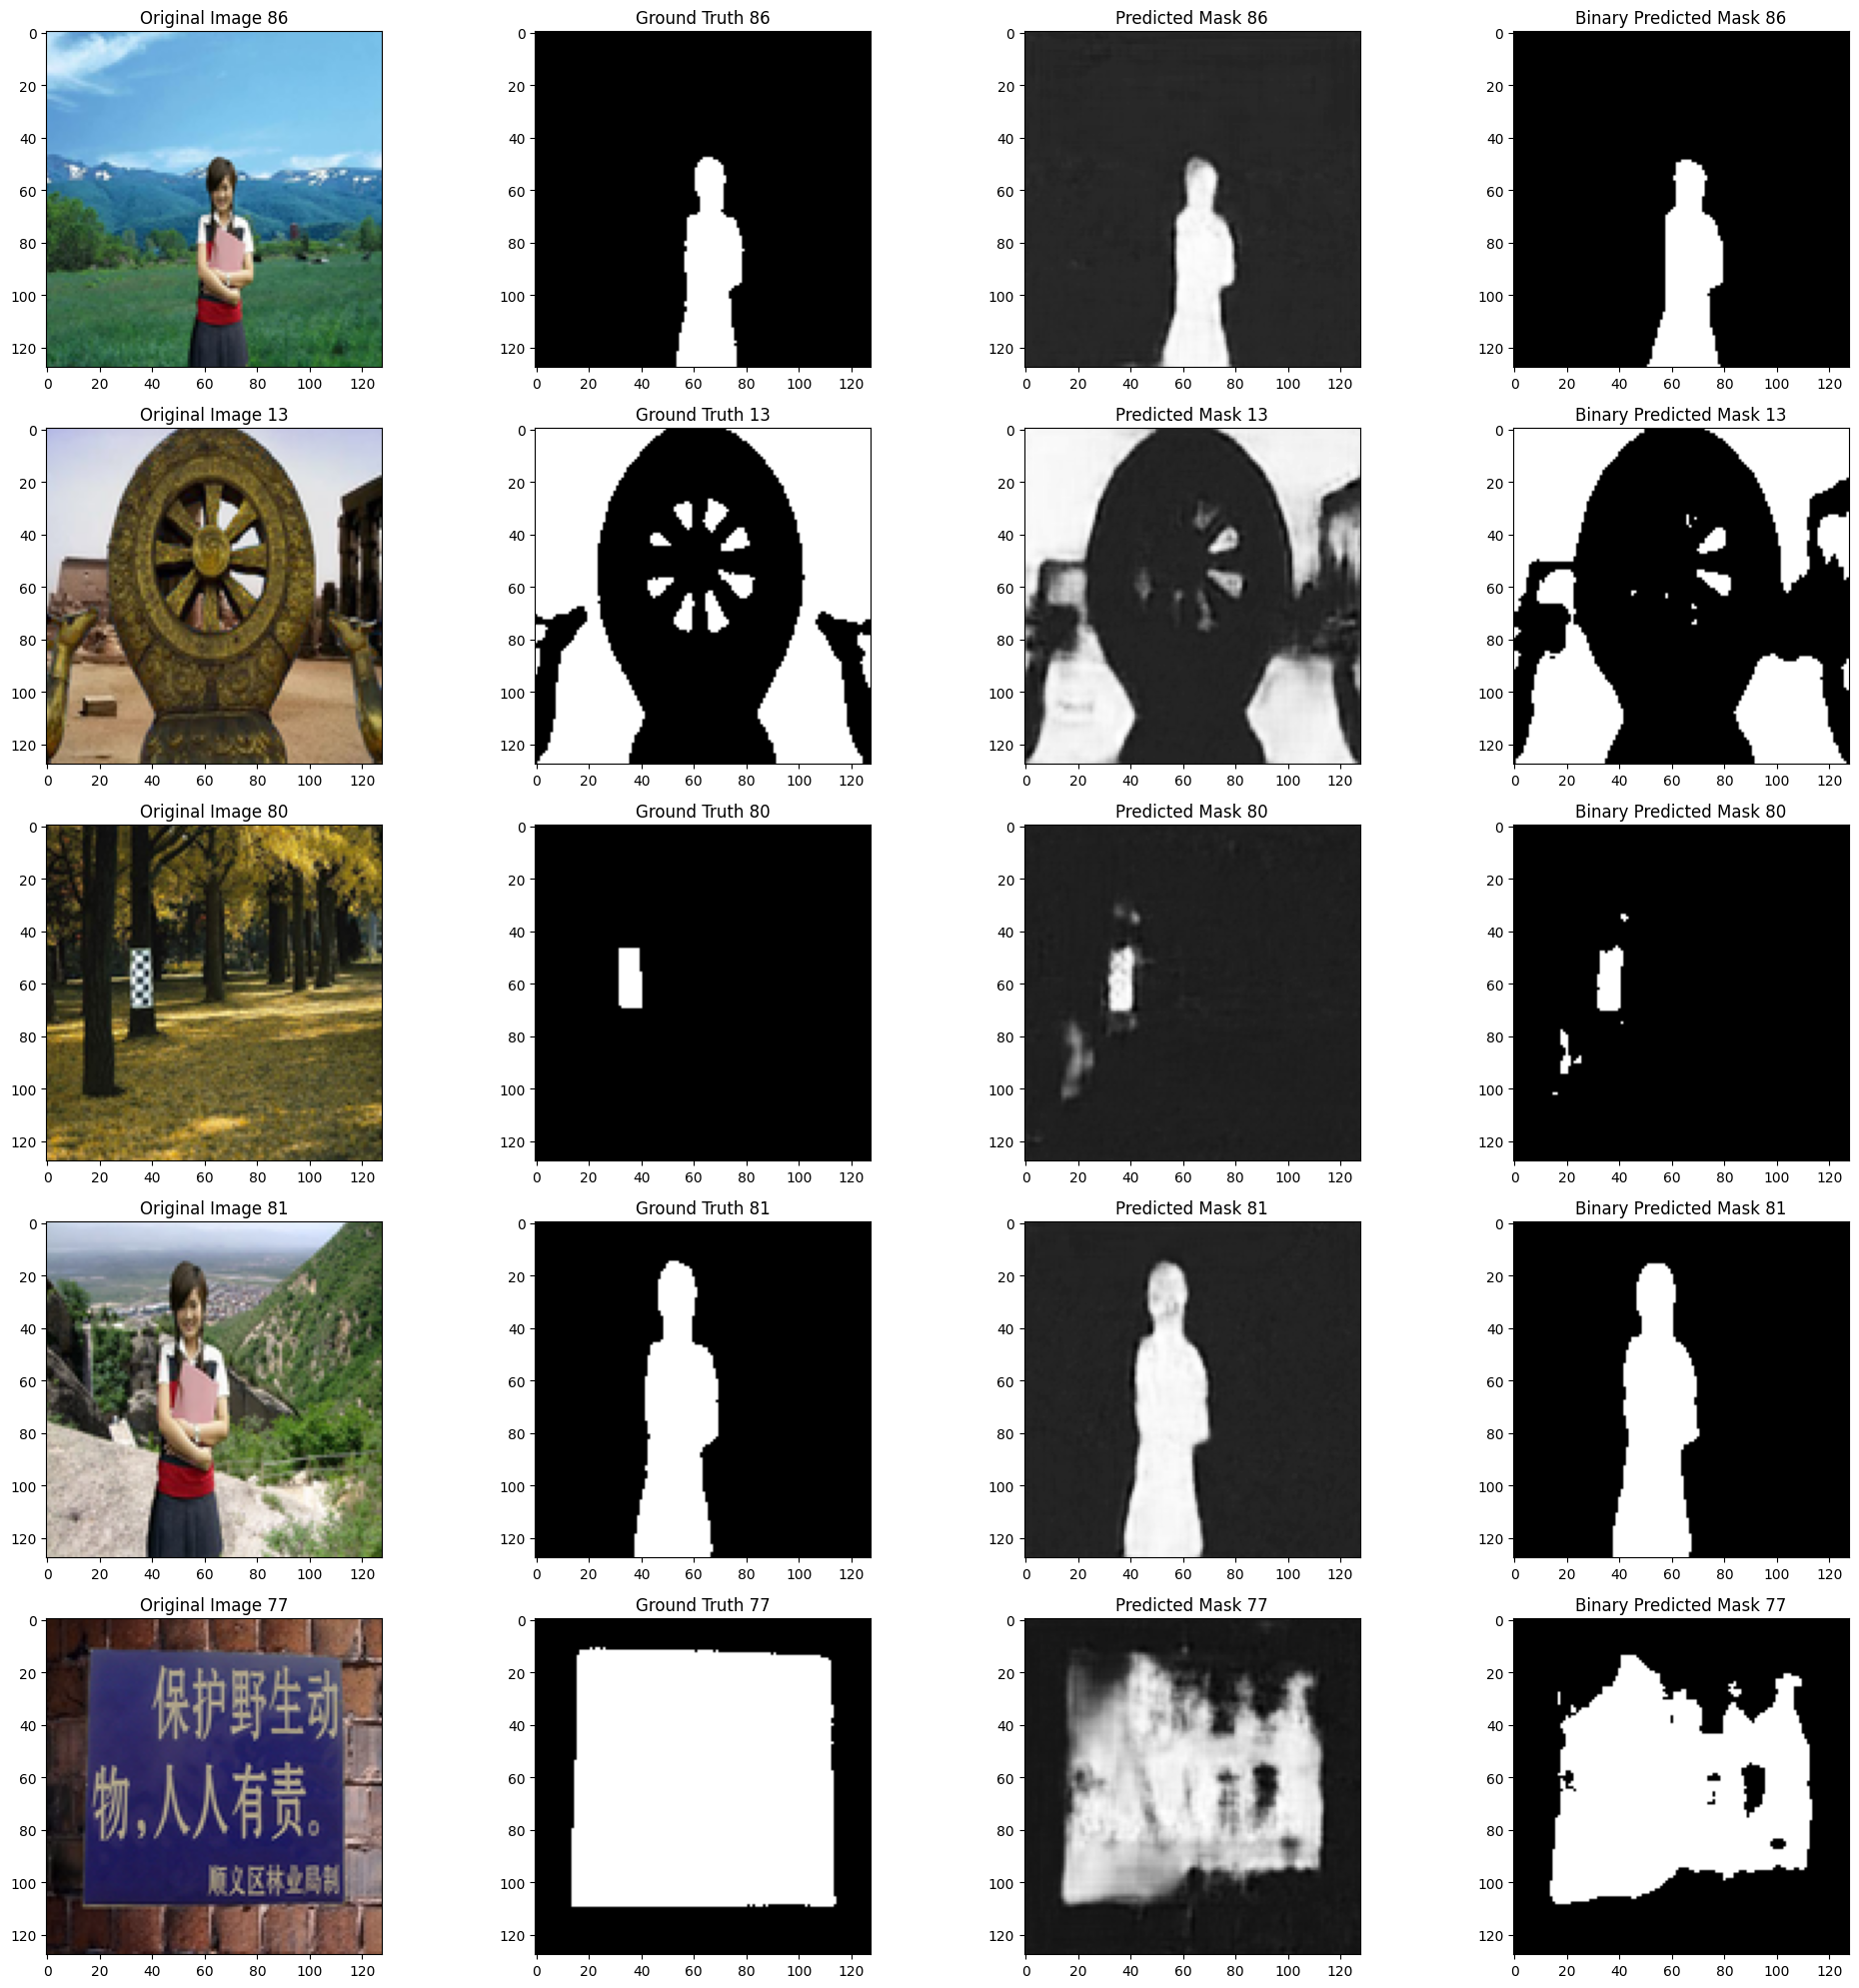

In [ ]:
import random

# Assuming x_test, y_test, and y_pred are your data
num_samples_to_show = 5
indices_random_5 = random.sample(range(len(x_test)), num_samples_to_show)

threshold = 0.5  # Adjust the threshold as needed

# Convert y_pred to binary masks using the threshold
y_pred_binary = (y_pred > threshold).astype('uint8')

# Set up the subplots
fig, axes = plt.subplots(num_samples_to_show, 4, figsize=(20, 20))

# Loop over the random indices
for i, idx in enumerate(indices_random_5):
    # Convert the images to uint8 for displaying
    original_image = (x_test[idx] * 255.0).astype('uint8')
    ground_truth = (y_test[idx] * 255.0).astype('uint8')
    predicted_mask = (y_pred[idx] * 255.0).astype('uint8')
    predicted_mask_binary = (y_pred_binary[idx] * 255.0).astype('uint8')

    # Display original image
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title(f'Original Image {idx}')

    # Display ground truth
    axes[i, 1].imshow(ground_truth, cmap='gray')
    axes[i, 1].set_title(f'Ground Truth {idx}')

    # Display predicted mask (original)
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].set_title(f'Predicted Mask {idx}')

    # Display predicted mask (binary)
    axes[i, 3].imshow(predicted_mask_binary, cmap='gray')
    axes[i, 3].set_title(f'Binary Predicted Mask {idx}')

plt.tight_layout()
plt.show()


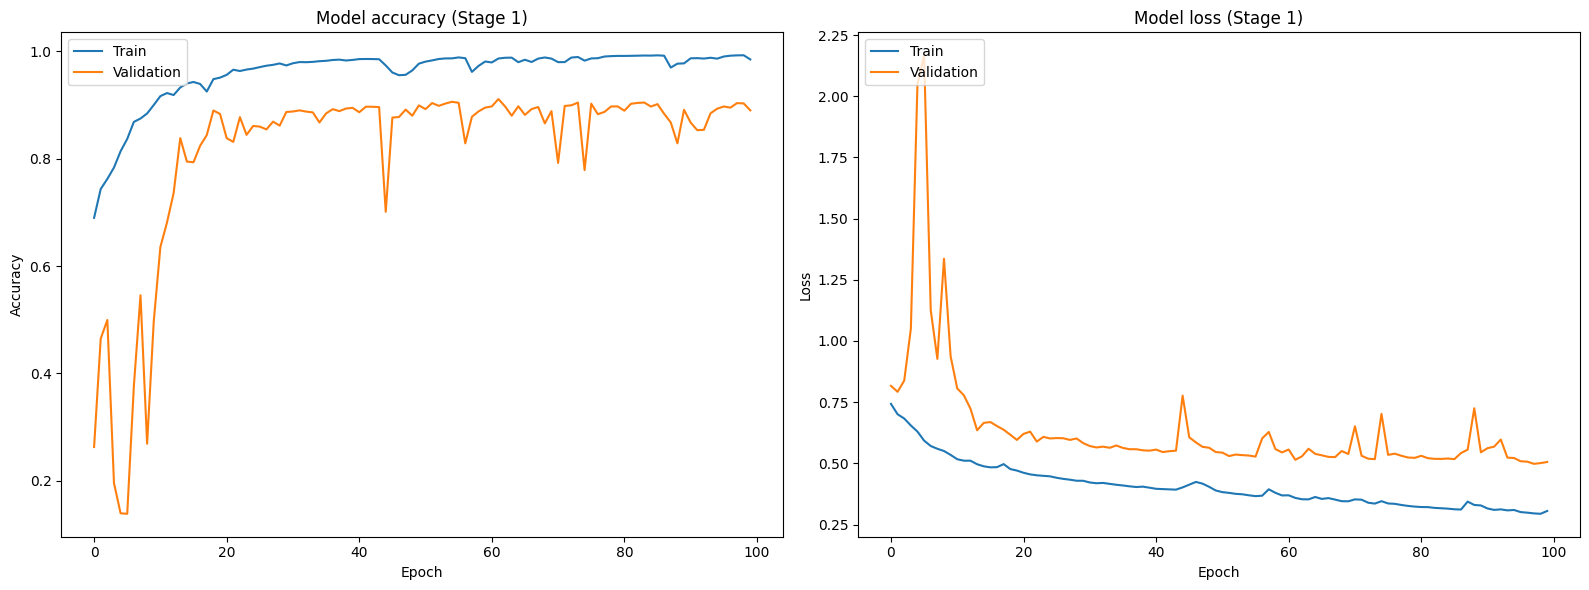

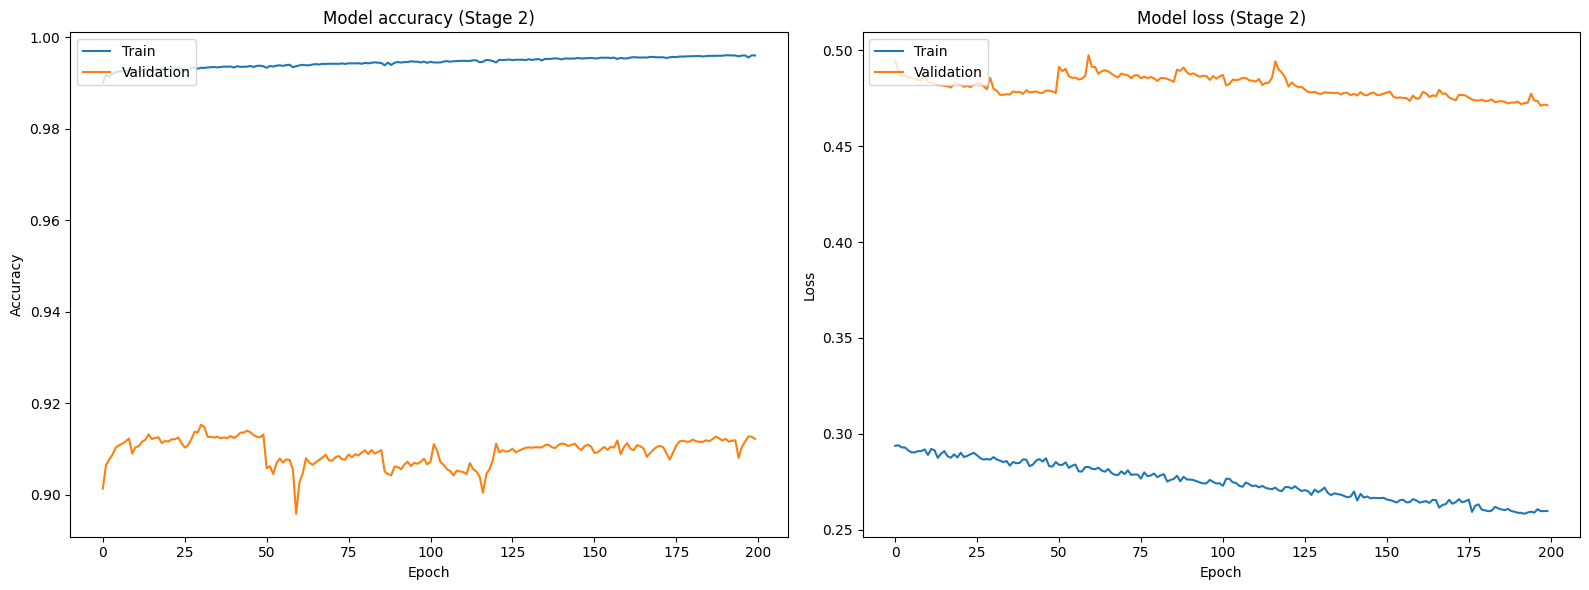

In [ ]:
# Plot both training histories side by side
plt.figure(figsize=(16, 6))

# Plot training accuracy values (Stage 1)
plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'])
plt.plot(history_stage1.history['val_accuracy'])
plt.title('Model accuracy (Stage 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training loss values (Stage 1)
plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'])
plt.plot(history_stage1.history['val_loss'])
plt.title('Model loss (Stage 1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Plot both training histories side by side
plt.figure(figsize=(16, 6))

# Plot training accuracy values (Stage 2)
plt.subplot(1, 2, 1)
plt.plot(history_stage2.history['accuracy'])
plt.plot(history_stage2.history['val_accuracy'])
plt.title('Model accuracy (Stage 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training loss values (Stage 2)
plt.subplot(1, 2, 2)
plt.plot(history_stage2.history['loss'])
plt.plot(history_stage2.history['val_loss'])
plt.title('Model loss (Stage 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()